In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
chemin_fichier_excel = "C:\\Users\\jean-\\Desktop\\Cours ENSAE\\statapp\\SX5Edec2021.xlsx"

df = pd.read_excel(chemin_fichier_excel, parse_dates=['Dates'])
df = df.rename(columns={'SX5E Index': 'Cours'})

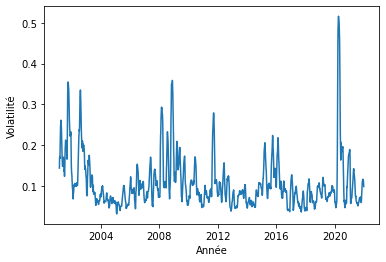

In [88]:
##D'abord on trace les graphiques sans rescaling des données 
#on commence par tracer la vol 60 jours 

df['Volatilite_60jours'] = df['Cours'].rolling(window=60).std()
df['Volatilite_60jours'] = df['Volatilite_60jours'] / 1000

import matplotlib.pyplot as plt

plt.gcf().clear()

# Tracer la volatilité sur 60 jours
plt.plot(df['Dates'], df['Volatilite_60jours'], label='Volatilité 60 jours')
plt.xlabel('Année')
plt.ylabel('Volatilité')

plt.show()

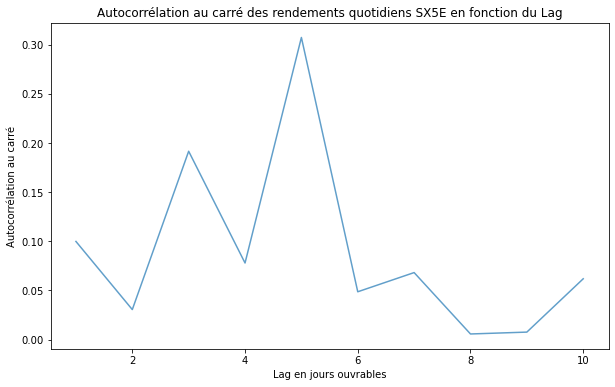

In [89]:
#ensuite on trace l'autocorrélation des rendements au carré

df['Rendements journaliers Xt en %'] = df['Cours'].pct_change()*100

# Calcul d'autocorrélation au carré des rendements quotidiens en fonction du lag
max_lag = 10
autocorr_squared = [(df['Rendements journaliers Xt en %'].autocorr(lag=i)**2) * 100 for i in range(1, max_lag + 1)]


plt.figure(figsize=(10, 6))  


plt.plot(range(1, max_lag + 1), autocorr_squared, marker='', linestyle='-', color='#1f77b4', alpha=0.7)
plt.title('Autocorrélation au carré des rendements quotidiens SX5E en fonction du Lag')
plt.xlabel('Lag en jours ouvrables')
plt.ylabel('Autocorrélation au carré')
plt.grid(False)

plt.show()

0.008401681047626406 1.439086372783911


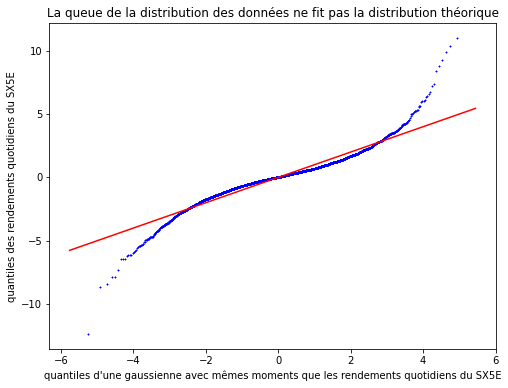

In [90]:
#puis on trace le qq plot des rendements quotidiens du SX5E
#dans le graphe donné en exemple, l'abscisse dit "gaussian quantiles when matching moments of historical daily perf SX5E"
#ça signifie qu'on compare nos quantiles des rdts journaliers du SX5E par rapport aux quantiles d'une distribution théorique 
#de variance mu et sigma? 

from scipy.stats import probplot

#on calcule les moments 
mu = np.mean(df['Rendements journaliers Xt en %'])
sigma = np.std(df['Rendements journaliers Xt en %'])
print(mu,sigma)
fig, ax = plt.subplots(figsize=(8, 6))
probplot(df['Rendements journaliers Xt en %'], dist='norm', sparams=(mu, sigma), plot=ax)
plt.plot(plt.xlim(),plt.xlim(),color='red', label='y=x')
plt.xlabel("quantiles d'une gaussienne avec mêmes moments que les rendements quotidiens du SX5E")
plt.ylabel("quantiles des rendements quotidiens du SX5E")
plt.title('La queue de la distribution des données ne fit pas la distribution théorique')

ax.get_lines()[0].set_marker('+')
ax.get_lines()[0].set_markersize(2)
ax.get_lines()[0].set_markerfacecolor('blue')
ax.get_lines()[0].set_markeredgecolor('blue')

#on voit que ça fit mal, en particulier sur la queue. Ca fit + ou - bien sur [-2.5;2.5]

Text(0.5, 1.0, 'la volatilité passée permet de prédire la volatilité future')

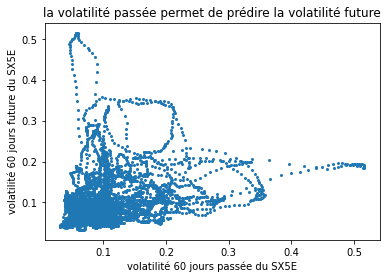

In [91]:
#puis on trace le graphe de vol 60d passés contre vol 60d future

df['Cours_futur'] = df['Cours'].shift(-60) #on décale de 60 jours dans le futur le cours et on re applique la même formule que pour la vol 60 jours passée
df['Volatilite_60jours_future'] = df['Cours_futur'].rolling(window=60).std()/1000
df = df.drop(columns=['Cours_futur'])

plt.scatter(df['Volatilite_60jours'],df['Volatilite_60jours_future'],s=4,marker='o')
plt.xlabel("volatilité 60 jours passée du SX5E")
plt.ylabel("volatilité 60 jours future du SX5E")
plt.title('la volatilité passée permet de prédire la volatilité future')

#on voit que la vol passée permet de prédire la vol future: si on faisait une rég future de vol future sur vol passée, 
#le coeff associé à vol passée n'est clairement pas nul 

Coefficient : 0.24017048316358422
Constante : 0.08054100716589195
R² : 0.05915760985319285


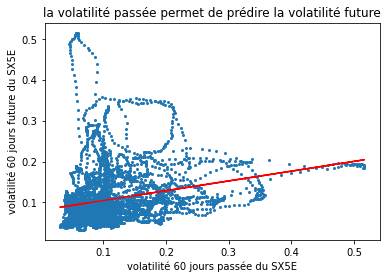

In [92]:
#test de reg linéaire de vol future sur vol passée 
from sklearn.linear_model import LinearRegression

model = LinearRegression()


x=df['Volatilite_60jours'].iloc[60:].iloc[:-60].to_numpy()
x=x.reshape(-1,1)
y=df['Volatilite_60jours_future'].iloc[60:].iloc[:-60].to_numpy()

model.fit(x,y)

Y_pred = model.predict(x)

# on trace le nuage de point et la droite de reg linéaire 
plt.scatter(x,y,s=4,marker='o')

plt.plot(x, Y_pred, color='red', label='Régression linéaire')


plt.xlabel("volatilité 60 jours passée du SX5E")
plt.ylabel("volatilité 60 jours future du SX5E")
plt.title('la volatilité passée permet de prédire la volatilité future')

print("Coefficient :", model.coef_[0])
print("Constante :", model.intercept_)
print("R² :", model.score(x,y))

